In [1]:
import pickle as pkl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.callbacks import CSVLogger

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [ ]:
plt.rcParams['figure.dpi']= 150 

In [2]:
from pipe import Data

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [15]:
def trim_padding(matrices):
    ## Trim the X of -1's. Might loose actual sequences
    padding_fractions = []
    padding_fraction = 0.9

    while padding_fraction > 0.5:

        padding_fraction = len(matrices[0][np.where(matrices[0] == -1)]) / (matrices[0].shape[0] * matrices[0].shape[1])
        padding_fractions.append(padding_fraction)
        trimming_factor = 0.1
        
        for i, m in enumerate(matrices):
            matrices[i] = m[:,int(m.shape[1]*trimming_factor) : m.shape[1] - int(m.shape[1]*trimming_factor)]
            
    return matrices

def build_model():
    #embedding_dims = 16
    hidden_dims = 512
    hidden_dims_2 = 256
    hidden_dims_3 = 128
    #maxlen = 

    model = Sequential()
    #model.add(Embedding(X_0.shape[1],
    #                    embedding_dims,
    #                    input_length=maxlen))

    #model.add(Dropout(0.2))
    model.add(Conv1D(512,
                     1024,
                     activation='relu',
                     strides=2))


    model.add(GlobalMaxPooling1D())

    model.add(Dense(hidden_dims))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))

    model.add(Dense(hidden_dims_2))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))

    model.add(Dense(hidden_dims_3))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

def fit_model(X, Y, Xt, Yt, filepath):
    batch_size = 500
    epochs = 30
    
    csv_logger = CSVLogger(filepath, append=True, separator=';')
    
    model = build_model()
    
    model.fit(X[..., np.newaxis], Y,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(Xt[..., np.newaxis], Yt),
              callbacks=[csv_logger])
    
    return model


In [5]:
amino = Data().load_conv_train()
gene = Data().load_conv_train(is_amino=False)

## Genes

In [6]:
targ_string = 'gene'
data = gene.copy()

In [7]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.3, replace = True).copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)


In [8]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

trimmed = trim_padding([X_0, X_0_test])
X_0, X_0_test = trimmed[0], trimmed[1]

trimmed = trim_padding([X_1, X_1_test])
X_1, X_1_test = trimmed[0], trimmed[1]

X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1

In [ ]:
model=fit_model(X, Y, X_test, Y_test, f'logs/{targ_string}_log.csv')




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 374 samples, validate on 150 samples
Epoch 1/30





374/374 [==============================] - 23s 60ms/step - loss: 0.6986 - acc: 0.5321 - val_loss: 2.8584 - val_acc: 0.4933
Epoch 2/30
374/374 [==============================] - 14s 38ms/step - loss: 2.8965 - acc: 0.5267 - val_loss: 2.4300 - val_acc: 0.5067
Epoch 3/30
374/374 [==============================] - 14s 37ms/step - loss: 2.4864 - acc: 0.4786 - val_loss: 0.6976 - val_acc: 0.4933
Epoch 4/30
374/374 [==============================] - 16s 43ms/step - loss: 1.2143 - acc: 0.4840 - val_loss: 1.2343 - val_acc: 0.4933
Epoch 5/30


In [ ]:
Y_pred = model.predict(X_test[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [ ]:
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

## Amino Acids

In [ ]:
targ_string = 'amino':
data = amino.copy()

In [6]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.3, replace = True).copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)


,drug_fingerprint,target_amino_code,label,set,d_enc,t_enc,d_len,t_len,d_enc_p,t_enc_p
0,2246728737 3542456614 2245384272 1506563592 22...,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...","[10, 0, 6, 18, 14, 5, 9, 13, 9, 12, 5, 1, 9, 0...",3003,622,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2246728737 3537119515 2245273601 2423543607 22...,MKQRFSALQLLKLLLLLQPPLPRALREALCPEPCNCVPDGALRCPG...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[10, 8, 13, 14, 4, 15, 0, 9, 13, 9, 9, 8, 9, 9...",1769,699,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,2246728737 3537119515 2245273601 2423543607 22...,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[10, 0, 11, 15, 0, 15, 12, 3, 13, 11, 13, 11, ...",1769,328,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,2968968094 2142032900 2968968094 2117068077 29...,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,1.0,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[10, 9, 10, 0, 15, 16, 16, 15, 0, 18, 12, 5, 6...",1431,371,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,2968968094 2142032900 2968968094 2117068077 29...,MRLSAGPDAGPSGNSSPWWPLATGAGNTSREAEALGEGNGPPRDVR...,1.0,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[10, 14, 9, 15, 0, 5, 12, 2, 0, 5, 12, 15, 5, ...",1431,418,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [ ]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

trimmed = trim_padding([X_0, X_0_test])
X_0, X_0_test = trimmed[0], trimmed[1]

trimmed = trim_padding([X_1, X_1_test])
X_1, X_1_test = trimmed[0], trimmed[1]

X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1

In [ ]:
model=fit_model(X, Y, X_test, Y_test, f'logs/{targ_string}_log.csv')

In [ ]:
Y_pred = model.predict(X_test[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [ ]:
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

## Validation

In [ ]:
data = amino.copy()

In [ ]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.3, replace = True).copy()
val   = data[data.set=='val'].copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)


In [38]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

X_0_val = np.array(val['d_enc_p'].tolist())
X_1_val = np.array(val['t_enc_p'].tolist())
Y_val = np.array(val['label'].tolist())

trimmed = trim_padding([X_0, X_0_test, X_0_val])
X_0, X_0_test, X_0_val = trimmed[0], trimmed[1], trimmed[2]

trimmed = trim_padding([X_1, X_1_test, X_1_val])
X_1, X_1_test,X_1_val  = trimmed[0], trimmed[1], trimmed[2]

# +1 to shift all values by 1 so the -1 padding becomes 0.
X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1
X_val = np.hstack((X_0_val, X_1_val)) + 1

In [79]:
X_mixed_index = np.random.randint(len(X), size=int(len(X)/2))
X_val_mixed_index = np.random.randint(len(X_val), size=int(len(X_val)/2))

In [95]:
Y[X_mixed_index].shape

(10432,)

In [96]:
Y_val[X_val_mixed_index].shape

(6988,)

In [99]:
X_mixed = np.vstack((X[X_mixed_index], X_val[X_val_mixed_index]))
X_mixed_val = np.vstack((X[~ X_mixed_index], X_val[ ~ X_val_mixed_index]))

#Y is shaped as a horizontal array
Y_mixed = np.hstack((Y[X_mixed_index], Y_val[X_val_mixed_index]))
Y_mixed_val = np.hstack((Y[~X_mixed_index], Y_val[~X_val_mixed_index]))

In [30]:
model=fit_model(X_mixed, Y_mixed, X_test, Y_test, f'logs/{targ_string}_val_log.csv')

In [106]:
Y_pred = model.predict(X_mixed_val[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

Train on 17420 samples, validate on 8444 samples
Epoch 1/30
17420/17420 [==============================] - 29s 2ms/step - loss: 0.6055 - acc: 0.6625 - val_loss: 0.7405 - val_acc: 0.5338
Epoch 2/30
17420/17420 [==============================] - 28s 2ms/step - loss: 0.6078 - acc: 0.6623 - val_loss: 0.6038 - val_acc: 0.6826
Epoch 3/30
17420/17420 [==============================] - 29s 2ms/step - loss: 0.5685 - acc: 0.6982 - val_loss: 0.5946 - val_acc: 0.6711
Epoch 4/30
17420/17420 [==============================] - 28s 2ms/step - loss: 0.5508 - acc: 0.7200 - val_loss: 0.5560 - val_acc: 0.7072
Epoch 5/30
17420/17420 [==============================] - 29s 2ms/step - loss: 0.5093 - acc: 0.7525 - val_loss: 0.5264 - val_acc: 0.7448
Epoch 6/30
17420/17420 [==============================] - 28s 2ms/step - loss: 0.6387 - acc: 0.6614 - val_loss: 0.6076 - val_acc: 0.6813
Epoch 7/30
17420/17420 [==============================] - 31s 2ms/step - loss: 0.5877 - acc: 0.6885 - val_loss: 0.6354 - val_acc:

In [ ]:
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

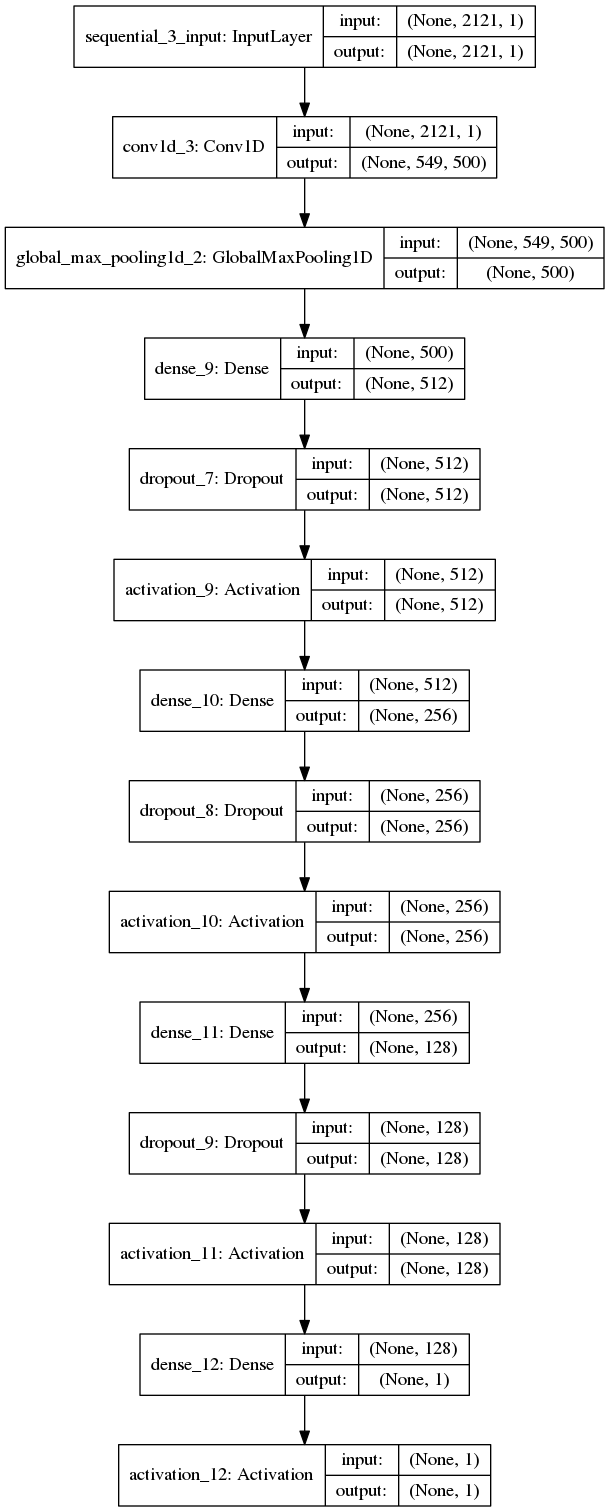

In [26]:
plot_model(model, show_shapes = True)

In [59]:
# model.save('data/models/pure_cnn_amino.model')